In [1]:
import numpy as np
import torch

import torch.nn.functional as F
from torch.utils.data import DataLoader

from matplotlib import pyplot as plt

from lafomo.datasets import ToyTranscriptomics, ReactionDiffusion, HomogeneousReactionDiffusion, P53Data
from lafomo.models import NeuralOperator, NeuralLFM
from lafomo.trainers import NeuralOperatorTrainer
from lafomo.plot import Plotter, plot_spatiotemporal_data, tight_kwargs
from lafomo.utilities.data import generate_neural_dataset_1d

In [2]:
from torch.nn.functional import softplus
from lafomo.utilities.data import context_target_split as cts
def show_result(model, loader, plotter=None):
    model.eval()
    x, y, params = next(iter(loader))
    x_context, y_context, _, _ = cts(x, y, x.shape[1], 0)
    p_y_pred, params_out = model(x_context, y_context, x, y)

    t = x[0, :, 0]
    fig, axes = plt.subplots(ncols=2, figsize=(8, 3))
    for i in range(1, 5):
        axes[0].plot(t, x[0, :, i])#.shape, y.shape)
    axes[1].plot(t, y[0, :, 0], label='Target')

    # mean = out[0, :, 0].detach()
    # std = softplus(out[0, :, 1].detach()).sqrt()
    mean = p_y_pred.mean[0].detach()
    std = p_y_pred.variance[0].sqrt().detach()
    # axes[1].plot(t, mean, label='Prediction')
    # axes[1].fill_between(t, mean + std, mean - std, label='Target')
    axes[1].errorbar(t, mean, std, label='Prediction')
    axes[1].legend()
    print(params.shape)
    num_outputs = params.shape[2]
    params = params.view(params.shape[0], -1)[0]
    params_out = params_out[0].detach()
    if plotter is not None:
        plotter.plot_double_bar(params_out.view(3, 5),
                                ['basal', 'sensitivity', 'decay'], ground_truths=params.view(3, 5))
    else:
        plotter = Plotter(model, np.array(['']*num_outputs))
        plotter.plot_double_bar(params_out.view(3, num_outputs),
                                ['basal', 'sensitivity', 'decay'], ground_truths=params.view(3, 5))


In [3]:
i = 3
width = 20
modes = 4
in_channels = 6
block_dim = 1
learning_rate = 1e-3
batch_size = 20

dataset = ToyTranscriptomics(data_dir='../../../data')
ntrain = len(dataset.train_data)
ntest = len(dataset.test_data)
train_loader = DataLoader(dataset.train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset.test_data, batch_size=ntest, shuffle=True)
num_outputs = 10

print(ntrain, ntest)
print(train_loader.dataset[0][0].shape)

500 10
torch.Size([11, 6])


In [4]:
# model = NeuralOperator(block_dim, in_channels, modes, width)
r_dim = z_dim = 9
model = NeuralLFM(block_dim, in_channels, modes, width, r_dim, z_dim)
print(model.count_params())

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
trainer = NeuralOperatorTrainer(model, [optimizer], train_loader, test_loader)

-1


In [7]:
trainer.train(20);

Epoch 001/020 - Loss: 20.32 (20.97 0.00 0.00 0.89 0.42)
Epoch 002/020 - Loss: 15.98 (17.11 0.00 0.00 0.38 0.42)
Epoch 003/020 - Loss: 14.57 (15.38 0.00 0.00 0.37 0.39)
Epoch 004/020 - Loss: 14.10 (15.13 0.00 0.00 0.36 0.40)
Epoch 005/020 - Loss: 13.65 (14.62 0.00 0.00 0.36 0.42)
Epoch 006/020 - Loss: 12.94 (14.02 0.00 0.00 0.36 0.40)
Epoch 007/020 - Loss: 12.13 (12.08 0.00 0.00 0.35 0.40)
Epoch 008/020 - Loss: 11.48 (12.60 0.00 0.00 0.35 0.42)
Epoch 009/020 - Loss: 11.32 (13.18 0.00 0.00 0.36 0.41)
Epoch 010/020 - Loss: 10.78 (12.08 0.00 0.00 0.35 0.40)
Epoch 011/020 - Loss: 10.86 (12.89 0.00 0.00 0.35 0.41)
Epoch 012/020 - Loss: 10.84 (11.65 0.00 0.00 0.35 0.40)
Epoch 013/020 - Loss: 10.11 (12.67 0.00 0.00 0.35 0.40)
Epoch 014/020 - Loss: 9.95 (10.95 0.00 0.00 0.34 0.42)
Epoch 015/020 - Loss: 9.87 (11.46 0.00 0.00 0.34 0.39)
Epoch 016/020 - Loss: 9.90 (10.22 0.00 0.00 0.34 0.39)
Epoch 017/020 - Loss: 9.95 (9.58 0.00 0.00 0.34 0.38)
Epoch 018/020 - Loss: 9.62 (10.30 0.00 0.00 0.33 0.41

torch.Size([10, 3, 5])


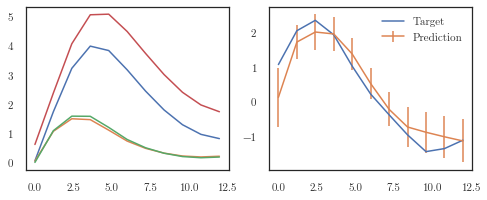

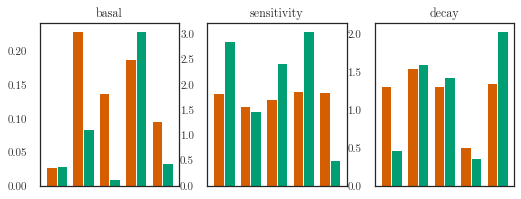

In [8]:
show_result(model, test_loader)

torch.Size([1, 3, 5])


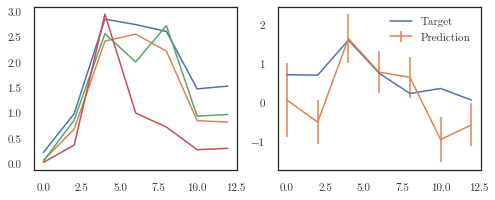

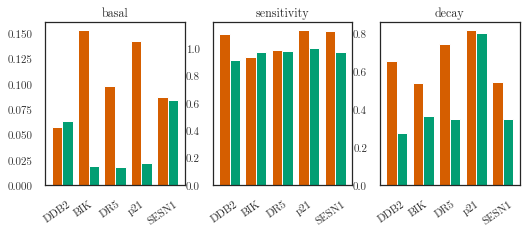

In [9]:
dataset = P53Data(data_dir='../../../data', replicate=0)
plotter = Plotter(model, dataset.gene_names)

train, test = generate_neural_dataset_1d(dataset.t_observed, [[dataset.m_observed, dataset.f_observed]], [dataset.params])
p53_loader = DataLoader(train, batch_size=1)
show_result(model, p53_loader, plotter)

In [ ]:
show_result(model, subsampled_loader)
show_result(model, high_res_loader)

In [ ]:
d
torch.save(model.state_dict(), './saved_model3205.pt')

